In [40]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torch
import numpy as np
from tqdm import trange

In [41]:
test_path = './data/sign_mnist_test.csv'
train_path = './data/sign_mnist_train.csv'
def fectch():
	train_data = np.genfromtxt(train_path, delimiter=',', dtype=np.int32)
	X_train = train_data[1:,1:]
	Y_train = train_data[1:,0]

	test_data = np.genfromtxt(test_path, delimiter=',', dtype=np.int32)
	X_test = test_data[1:,1:]
	Y_test= test_data[1:,0]
	return X_train, Y_train, X_test, Y_test

In [ ]:

def train(model, X_train, Y_train, optim, steps, lossfn, BS=128):
	losses, accuracies = [], []
	for _ in (t := trange(steps)):
		samp = np.random.randint(0, X_train.shape[0], size=BS)
		x = Tensor(X_train[samp]).type(torch.float32)
		y = Tensor(Y_train[samp]).type(torch.uint8)
		
		# forward pass: compute predicted outputs by passing inputs to the model
		out = model.forward(x)
		# calculate the loss
		loss = lossfn(out, y)
		# clear the gradients of all optimized variables
		optimizer.zero_grad()
		# backward pass: compute gradient of the loss with respect to model parameters
		loss.backward()
		# perform a single optimization step (parameter update)
		optim.step()

		cat = np.argmax(out.detach().numpy(), axis=-1)
		accuracy = (cat == y.numpy()).mean()
		loss = loss.detach().numpy()
		losses.append(loss)
		accuracies.append(accuracy)
		t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
					
	return [losses, accuracies]

def evaluate(model, X_test, Y_test, num_classes=25, BS=128):
	def numpy_eval(Y_test, num_classes):
		Y_test_preds_out = np.zeros(list(Y_test.shape)+[num_classes])
		for i in trange((len(Y_test)-1)//BS+1):
			x = Tensor(X_test[i*BS:(i+1)*BS])
			out = model.forward(x)

			Y_test_preds_out[i*BS:(i+1)*BS] = out.detach().numpy()
		Y_test_preds = np.argmax(Y_test_preds_out, axis=-1)
		return (Y_test == Y_test_preds).mean(), Y_test_preds

	acc, Y_test_pred = numpy_eval(Y_test, num_classes)
	print("test set accuracy is %f" % acc)
	return (acc, Y_test_pred) #if return_predict else acc

f = 8
class MLP(nn.Module):
	def __init__(self):
		super(MLP, self).__init__()
		self.fc1 = nn.Linear(28 * 28, 1024*f, dtype=torch.float32)
		self.fc2 = nn.Linear(1024*f, 1024*f, dtype=torch.float32)
		self.fc3 = nn.Linear(1024*f, 1024*f, dtype=torch.float32)
		self.fc4 = nn.Linear(1024*f, 25, dtype=torch.float32)
		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = self.dropout(F.relu(self.fc1(x)))
		x = self.dropout(F.relu(self.fc2(x)))
		x = self.dropout(F.relu(self.fc3(x)))
		#x = F.relu(self.fc1(x))
		#x = F.relu(self.fc2(x))
		x = self.fc4(x)
		return x

In [48]:
def test(x, y, gt=None):
	import matplotlib.pyplot as plt
	from random import randint
	numbers = list(range(0, 26))
	letters = [chr(i) for i in list(range(ord('A'), ord('Z')+1))]
	i2c = {k:v for (k, v) in zip(numbers, letters)}
	n = x.shape[0]
	imgs = x.reshape((n, 28, 28))
	plt.figure(figsize=(10,8))
	for i in range(12):
		idx = randint(0, n)
		plt.subplot(4, 3, i+1)
		plt.imshow(imgs[idx], cmap='gray')
		plt.axis('off')
		plt.title(f'Prediction: {i2c.get(gt[idx])} GT: ({i2c.get(y[idx])})') if gt.any() else plt.title(i2c.get(y[idx]))
	plt.show()

100%|██████████| 57/57 [00:02<00:00, 26.99it/s]


test set accuracy is 0.786949


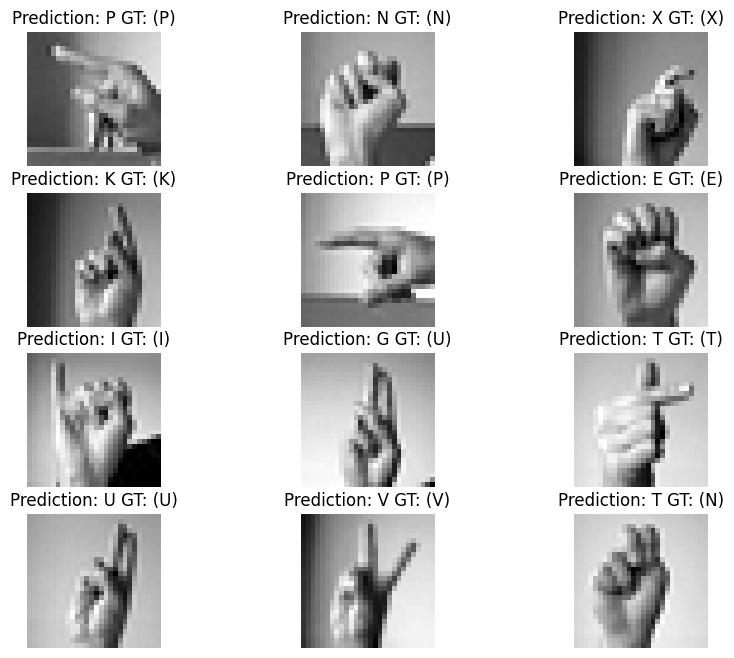

In [50]:
X_train, Y_train, X_test, Y_test = fectch()

model = MLP()
# specify loss function
lossfn = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
train(model, X_train, Y_train, optimizer, steps=10000, lossfn=lossfn)
acc, y_test_pred = evaluate(model, X_test, Y_test)
test(X_test, Y_test, y_test_pred)